In [1]:
import pickle
import pathlib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

c:\Users\Pedro Antônio Silva\Desktop\Semestre 4\Machine Learning\proj_1\ames\data


In [3]:
def nonNull_percent(label, null_value = 0 ):
    f = data[label] != null_value
    return (data[label][f].value_counts().sum()/data[label].shape[0] *100)

In [4]:
def heatMapCorr(labels):
    correlation_matrix = data[labels + ["SalePrice"]].corr()

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Heatmap')
    plt.show()

In [ ]:
model_data = data.copy()
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()
model_data = pd.get_dummies(model_data, drop_first=True)
model_data.info()
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

In [ ]:
data = model_data

array([[<AxesSubplot:title={'center':'Lot.Frontage'}>,
        <AxesSubplot:title={'center':'Lot.Area'}>,
        <AxesSubplot:title={'center':'Mas.Vnr.Area'}>,
        <AxesSubplot:title={'center':'BsmtFin.SF.1'}>,
        <AxesSubplot:title={'center':'BsmtFin.SF.2'}>,
        <AxesSubplot:title={'center':'Bsmt.Unf.SF'}>],
       [<AxesSubplot:title={'center':'Total.Bsmt.SF'}>,
        <AxesSubplot:title={'center':'X1st.Flr.SF'}>,
        <AxesSubplot:title={'center':'X2nd.Flr.SF'}>,
        <AxesSubplot:title={'center':'Low.Qual.Fin.SF'}>,
        <AxesSubplot:title={'center':'Gr.Liv.Area'}>,
        <AxesSubplot:title={'center':'Bsmt.Full.Bath'}>],
       [<AxesSubplot:title={'center':'Bsmt.Half.Bath'}>,
        <AxesSubplot:title={'center':'Full.Bath'}>,
        <AxesSubplot:title={'center':'Half.Bath'}>,
        <AxesSubplot:title={'center':'Bedroom.AbvGr'}>,
        <AxesSubplot:title={'center':'Kitchen.AbvGr'}>,
        <AxesSubplot:title={'center':'TotRms.AbvGrd'}>],
       [<A

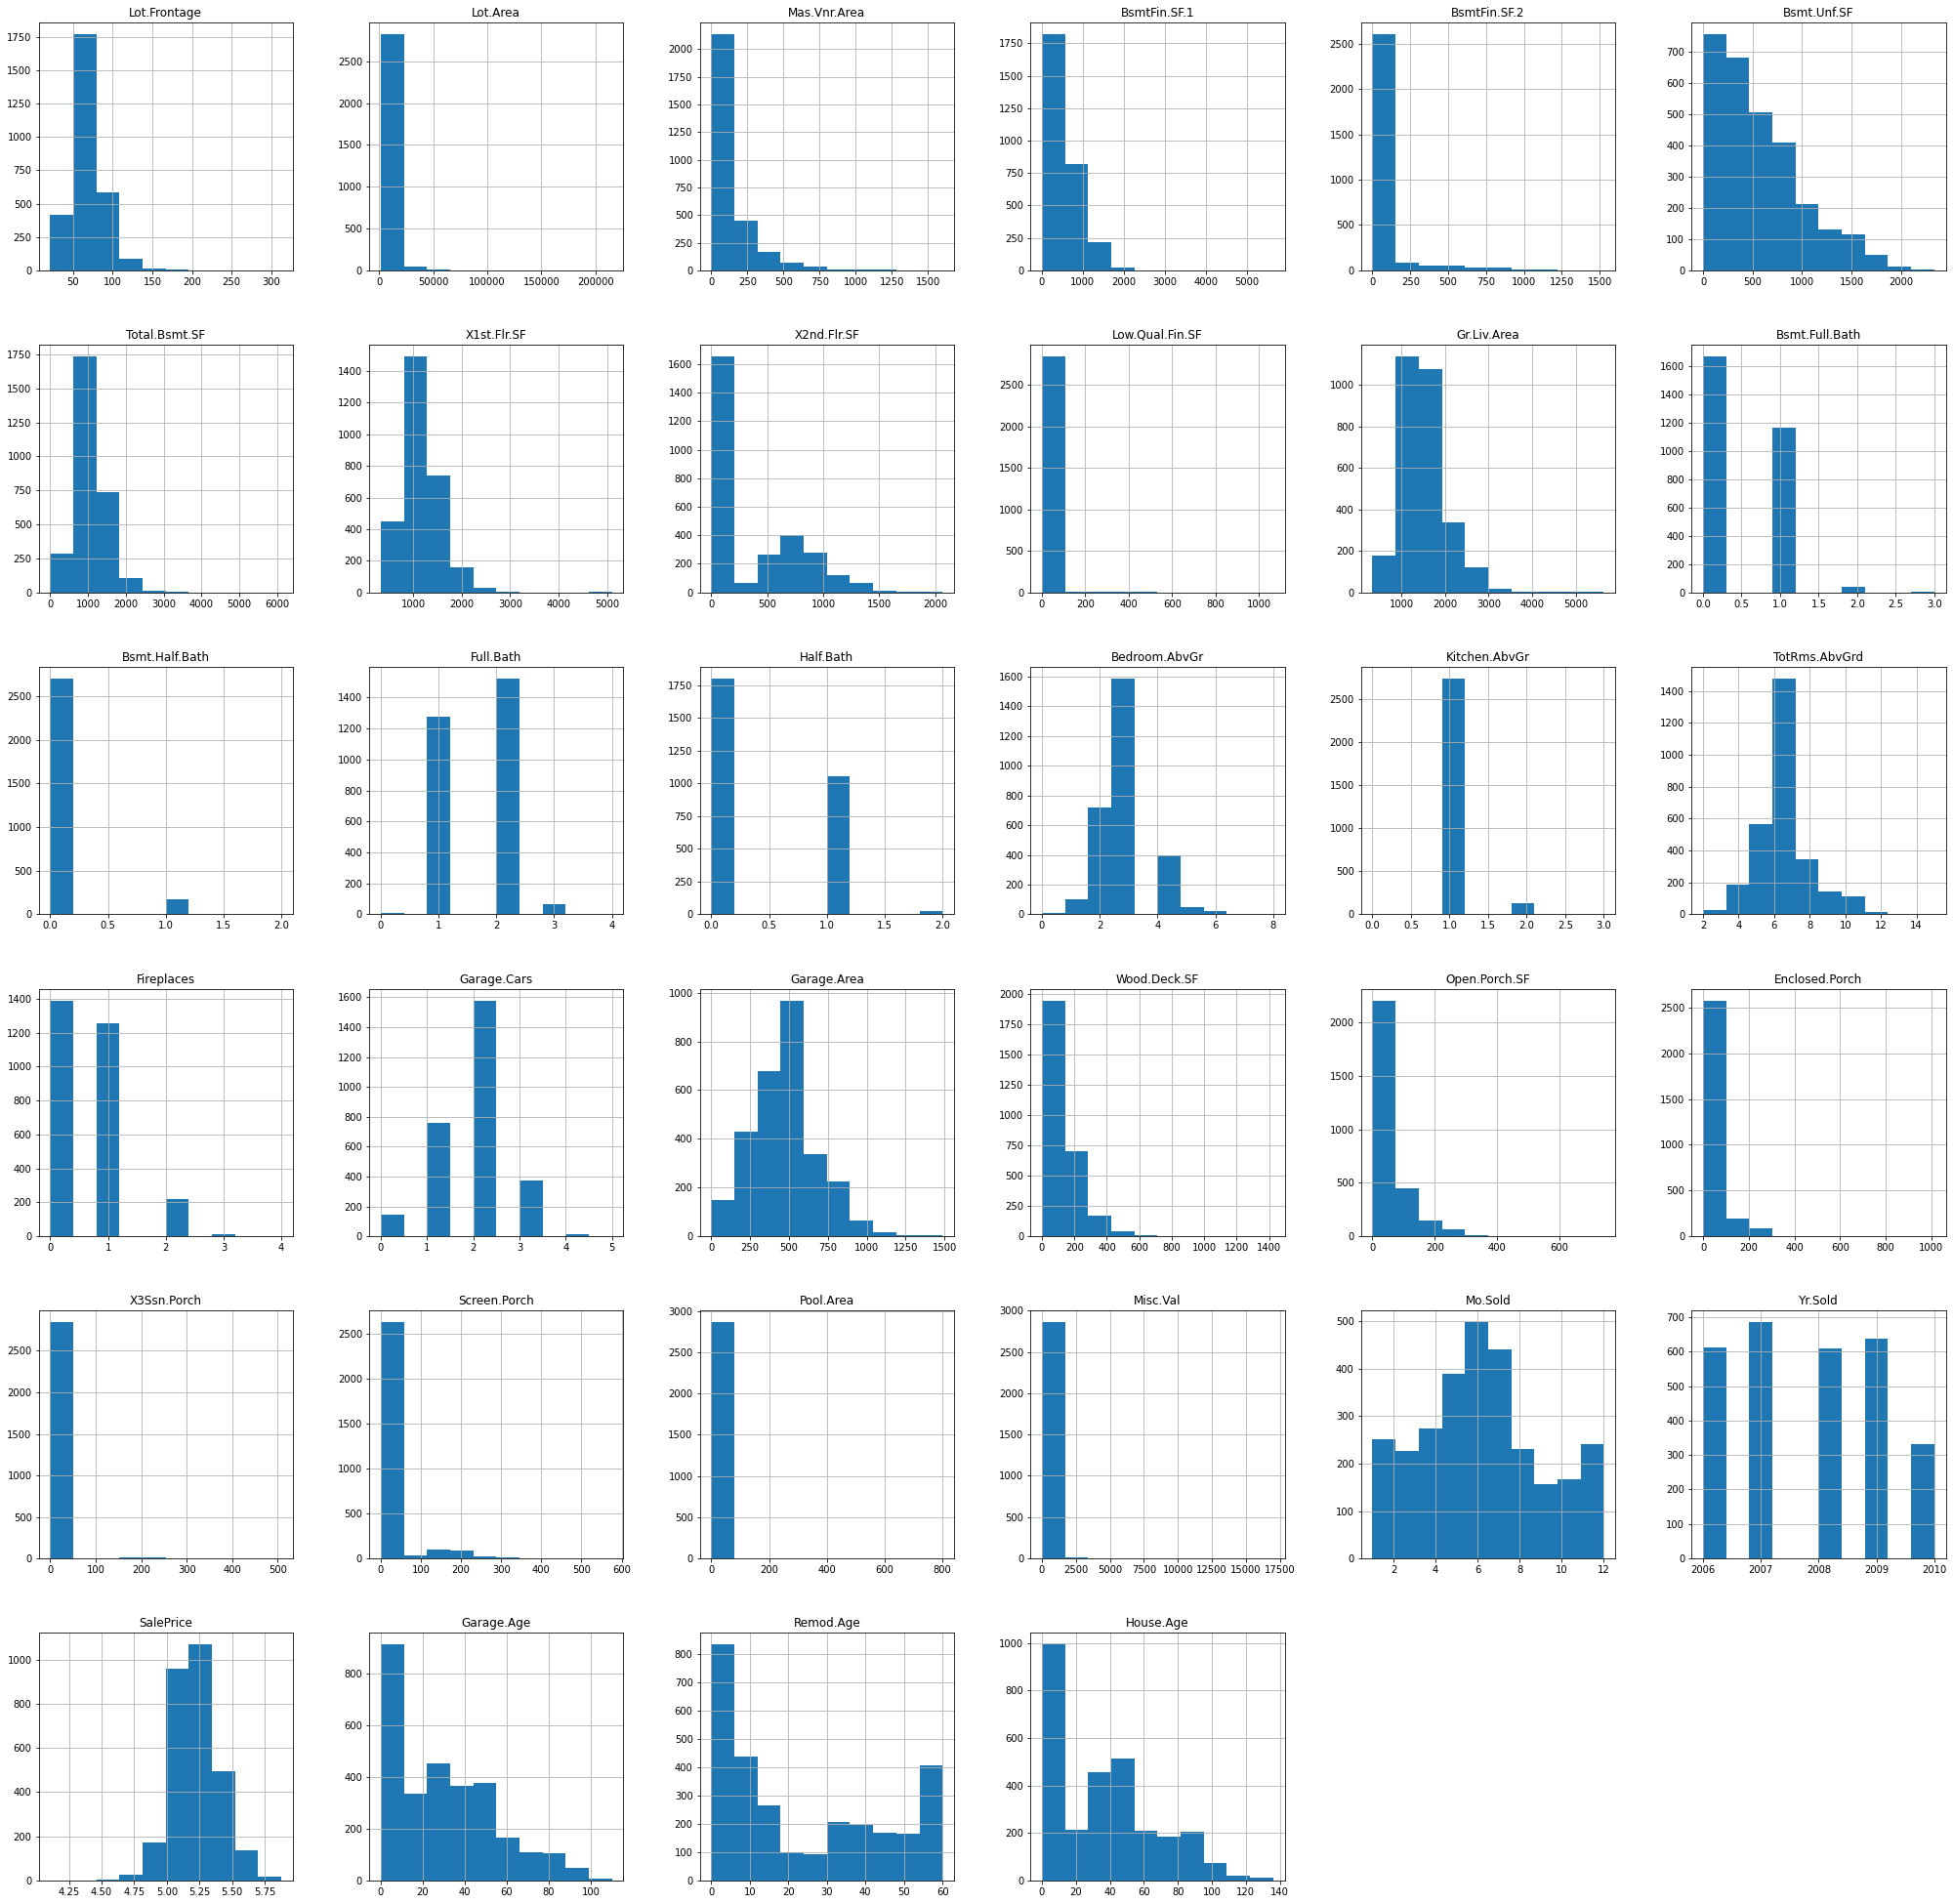

In [5]:
data.hist(figsize=(35,35))

In [6]:
## We could drop those...
dropList = []
# pool area - pool area =D
nonNull_percent("Pool.Area")
dropList.append("Pool.Area") # questionable but...

# X3Ssn.Porch - Three season porch area in square feet  }
# Screen.Porch - Screen porch area in square feet       } Results don't make sense, so leave it there...
# *Enclosed.Porch - Enclosed porch area in square feet  }

# Misc.Val - $Value of miscellaneous feature
nonNull_percent("Misc.Val")
dropList.append("Misc.Val")

# BsmtFin.SF.2 - Rating of basement finished area (if multiple types) - We'll see this later on the analysis.

# Lot.Area - Lot size in square feet - NOT REMOVE

# Kitchen.AbvGr
nonNull_percent("Kitchen.AbvGr", 1)
# dropList.append("Kitchen.AbvGr")
# Bsmt.Half.Bath
nonNull_percent("Bsmt.Half.Bath")
dropList.append("Bsmt.Half.Bath")
# Low.Qual.Fin.SF
nonNull_percent("Low.Qual.Fin.SF")
dropList.append("Low.Qual.Fin.SF")

# # Land.Slope - 
# nonNull_percent("Land.Slope")
# dropList.append("Land.Slope")     Didn't change or fucked up
# # Functional - 
# nonNull_percent("Functional")
# dropList.append("Functional")

# Mas.Vnr.Area -

# Electrical
nonNull_percent("Electrical")
# dropList.append("Electrical")

# Central.Air
# nonNull_percent("Central.Air_Y")
# dropList.append("Central.Air_Y")



100.0

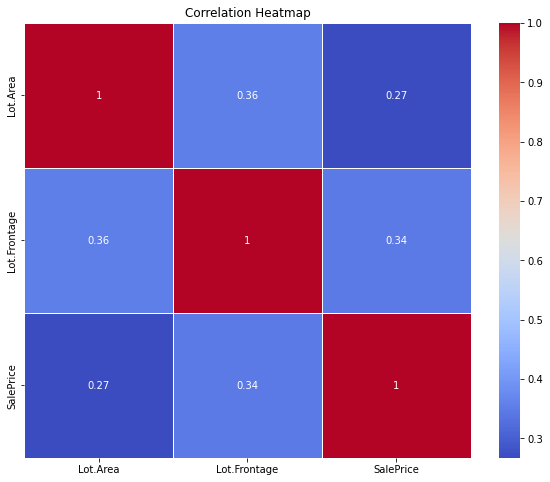

In [7]:
lot_cat = ["Lot.Area", "Lot.Frontage", "Lot.Shape"]
heatMapCorr(lot_cat)

In [8]:
# testing / visualization cell
# analyse = "Central.Air_Y"
# data[analyse].hist()
# nonNull_percent(analyse,1)

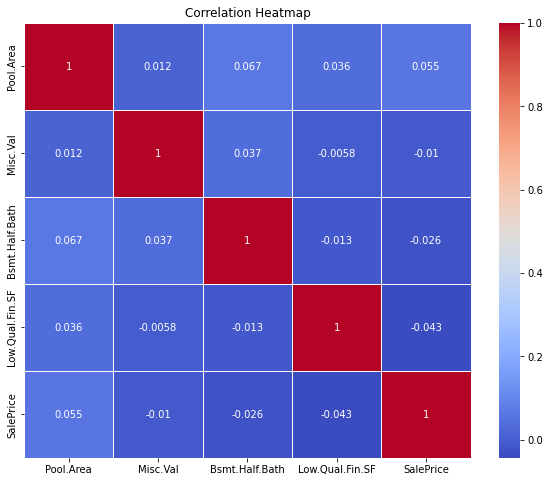

In [9]:
heatMapCorr(dropList)
data = data.drop(columns=dropList)

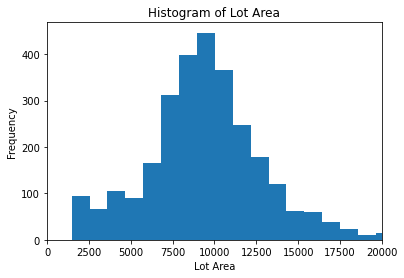

In [10]:
plt.hist(data["Lot.Area"], bins=200 )  # You can adjust the number of bins as needed
plt.xlabel("Lot Area")
plt.ylabel("Frequency")
plt.title("Histogram of Lot Area")
plt.xlim(0, 20000)
plt.show()

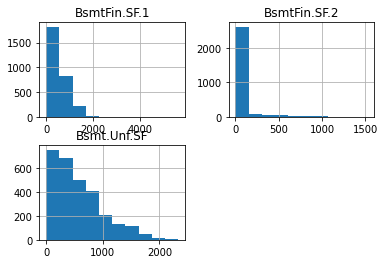

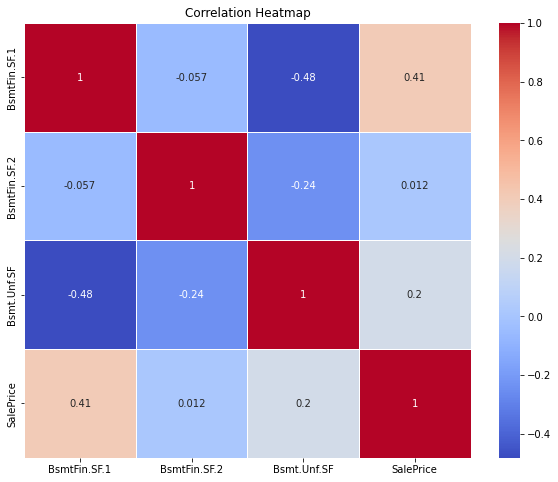

In [11]:
basement_cat = ["BsmtFin.SF.1","BsmtFin.SF.2", "Bsmt.Unf.SF"]
for col  in basement_cat:
    nonNull_percent(col)

data[basement_cat].hist()
heatMapCorr(basement_cat)

In [12]:
data = data.drop(columns=["BsmtFin.SF.2","Total.Bsmt.SF"])

In [13]:
porch_cat = ["Enclosed.Porch", "Screen.Porch", "X3Ssn.Porch"]
# data["Total.Porch.Area"] = data["Enclosed.Porch"] + data["Screen.Porch"] + data["X3Ssn.Porch"]

for cat in porch_cat:
    print(nonNull_percent(cat))

# print(nonNull_percent("Total.Porch.Area"))
# heatMapCorr(porch_cat+["Total.Porch.Area"])

# data = data.drop(columns=porch_cat)

15.363225582203684
8.86339937434828
1.251303441084463


In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, RobustScaler

model_data = data.copy()
y = model_data["SalePrice"].copy()
X = model_data.drop(columns=["SalePrice"]).copy()

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=12,)

piped_model = Pipeline([
    ("scaler", RobustScaler()),
    ("Transformer", PowerTransformer()),
    ("model", Ridge())
])

Rpred = piped_model
Rpred.fit(Xtrain,ytrain)

ypred = Rpred.predict(Xtest)
RMSE = np.sqrt(mean_squared_error(ytest, ypred))
print(f"RMSE = {RMSE}")
error_percent = 100 * (10**RMSE - 1)
print(f'Average error is {error_percent:.2f}%')

RMSE = 0.050171793394616304
Average error is 12.25%
